# Importing required Libraries and modules

In [4]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics



def printmd(string):
    display(Markdown(string))
    
    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


%matplotlib inline

# Loading the Income-Census Dataset

In [5]:
#importing the Income-Census dataset (in csv format)
#we are storing our dataset in "df" variable to make our job easier.
df=pd.read_csv(r'C:\Users\Sony\Desktop\Income.csv')

In [6]:
#checking the first five rows of the Dataset
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# Preliminary Data Analysis

In [7]:

# Setting all the categorical columns to type category
for col in set(df.columns) - set(df.describe().columns):
      df[col] = df[col].astype('category')
    
printmd('## 1.1. Columns and their types')
print(df.info())


## 1.1. Columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null category
fnlwgt            32561 non-null int64
education         32561 non-null category
education.num     32561 non-null int64
marital.status    32561 non-null category
occupation        32561 non-null category
relationship      32561 non-null category
race              32561 non-null category
sex               32561 non-null category
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null category
income            32561 non-null category
dtypes: category(9), int64(6)
memory usage: 1.8 MB
None


In [8]:

# Top 5 records
printmd('## 1.2. Data')
df.head()

## 1.2. Data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [9]:

printmd('## 1.3. Summary Statistics')

df.describe()

## 1.3. Summary Statistics

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:

printmd('## 1.4. Missing values')
for i,j in zip(df.columns,(df.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        printmd(str(i) + ': ' + str(j) + ' records')

## 1.4. Missing values

workclass: 1836 records

occupation: 1843 records

native.country: 583 records

# Treating Missing Values by predicting them

I fill the missing values in each of the three columns by predicting their values. For each of the three columns, I use all the attributes (including 'income') as independent variables and treat that column as the dependent variable, making it a multi-class classification task. I use three classification algorithms, namely, logistic regression, decision trees and random forest to predict the class when the value is missing (in this case a '?'). I then take a majority vote amongst the three classifiers to be the class of the missing value. In case of a tie, I pick the majority class of that column using the entire dataset.

In [11]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

In [12]:
printmd('### 1.4.1. Filling in missing values for Attribute workclass')

test_data = df[(df.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = df[(df.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = df.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

df.loc[(df.workclass.values == '?'),'workclass'] = overall_pred.values
print(df.workclass.value_counts())
print(df.workclass.unique())

### 1.4.1. Filling in missing values for Attribute workclass

C:\Users\Sony\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sony\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Private             24150
Self-emp-not-inc     2549
Local-gov            2097
State-gov            1298
Self-emp-inc         1116
Federal-gov           962
Never-worked          375
Without-pay            14
?                       0
Name: workclass, dtype: int64
[Private, State-gov, Federal-gov, Self-emp-not-inc, Self-emp-inc, Local-gov, Never-worked, Without-pay]
Categories (8, object): [Private, State-gov, Federal-gov, Self-emp-not-inc, Self-emp-inc, Local-gov, Never-worked, Without-pay]


In [13]:
printmd('### 1.4.2. Filling in missing values for Occupation occupation')

test_data = df[(df.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = df[(df.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = df.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

df.loc[(df.occupation.values == '?'),'occupation'] = overall_pred.values
print(df.occupation.value_counts())
print(df.occupation.unique())

### 1.4.2. Filling in missing values for Occupation occupation

C:\Users\Sony\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sony\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Prof-specialty       5155
Craft-repair         4255
Exec-managerial      4184
Adm-clerical         3888
Sales                3715
Other-service        3544
Machine-op-inspct    2042
Transport-moving     1611
Handlers-cleaners    1399
Farming-fishing      1008
Tech-support          936
Protective-serv       666
Priv-house-serv       149
Armed-Forces            9
?                       0
Name: occupation, dtype: int64
[Prof-specialty, Exec-managerial, Machine-op-inspct, Other-service, Adm-clerical, ..., Farming-fishing, Tech-support, Protective-serv, Armed-Forces, Priv-house-serv]
Length: 14
Categories (14, object): [Prof-specialty, Exec-managerial, Machine-op-inspct, Other-service, ..., Tech-support, Protective-serv, Armed-Forces, Priv-house-serv]


In [14]:
printmd('### 1.4.3. Filling in missing values for Native Country')

test_data = df[(df['native.country'].values == '?')].copy()
test_label = test_data['native.country']

train_data = df[(df['native.country'].values != '?')].copy()
train_label = train_data['native.country']

test_data.drop(columns = ['native.country'], inplace = True)
train_data.drop(columns = ['native.country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = df['native.country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

df.loc[(df['native.country'].values == '?'),'native.country'] = overall_pred.values
print(df['native.country'].value_counts())
print(df['native.country'].unique())

### 1.4.3. Filling in missing values for Native Country

C:\Users\Sony\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sony\Anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


United-States                 29728
Mexico                          648
Philippines                     203
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           101
Cuba                             95
England                          90
South                            88
Jamaica                          81
China                            77
Italy                            73
Dominican-Republic               70
Vietnam                          69
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                           29
France                      

In [15]:

# Resetting the categories

df['workclass'] = df['workclass'].cat.remove_categories('?')
df['occupation'] = df['occupation'].cat.remove_categories('?')
df['native.country'] = df['native.country'].cat.remove_categories('?')

In [16]:
printmd('## 1.5. Correlation Matrix')

display(df.corr())

printmd('We see that none of the columns are highly correlated.')

## 1.5. Correlation Matrix

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education.num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital.gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital.loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours.per.week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


We see that none of the columns are highly correlated.

# Univariate and Bivariate Analysis

In [17]:
# Creating a dictionary that contain the education and it's corresponding education level
edu_level = {}
for x,y in df[['education.num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

## 2.1. Education vs Income

I plot a bar graph showing the proportion of income classes across education levels         in the figure below. As one would expect, we see from the bar graph below that as the         education level increase, the proportion of people who earn more than 50k a year also         increase. It is interesting to note that only after a master's degree, the proportion of         people earning more than 50k a year, is a majority.

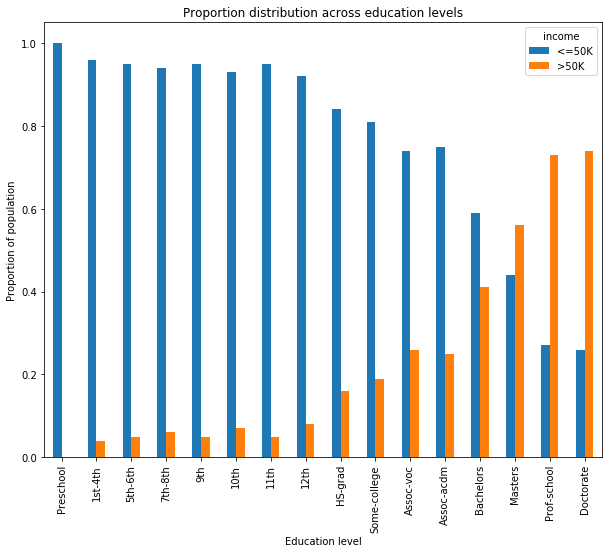

In [18]:

printmd('## 2.1. Education vs Income')

education = round(pd.crosstab(df.education,df.income).div(pd.crosstab(df.education,df.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Proportion distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across education levels \
        in the figure below. As one would expect, we see from the bar graph below that as the \
        education level increase, the proportion of people who earn more than 50k a year also \
        increase. It is interesting to note that only after a master\'s degree, the proportion of \
        people earning more than 50k a year, is a majority.')

## 2.2 Gender vs Income

We plot a bar graph showing the proportion of income classes across the genders in figure         below. From the graph, at an overall view, there exists a wage gap between females and males.         Since we do not have the exactly value of the income, we are limited to only observing that the         proportion of males earning more than 50k a year is more than double of their female counterparts.         

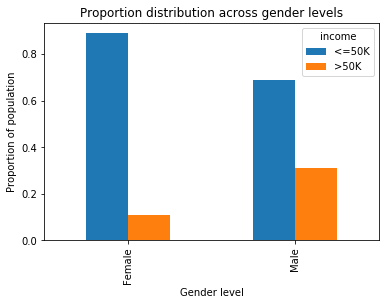

In [19]:
printmd('## 2.2 Gender vs Income')

gender = round(pd.crosstab(df.sex, df.income).div(pd.crosstab(df.sex,df.income).apply(sum,1),0),2)
gender.sort_values(by = '>50K', inplace = True)
ax = gender.plot(kind ='bar', title = 'Proportion distribution across gender levels')
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('We plot a bar graph showing the proportion of income classes across the genders in figure \
        below. From the graph, at an overall view, there exists a wage gap between females and males. \
        Since we do not have the exactly value of the income, we are limited to only observing that the \
        proportion of males earning more than 50k a year is more than double of their female counterparts. \
        ')

Taking a closer look at the disparity in income between men and women, plot the         proportion of men and women who earn more than 50k a year, across all the working         classes as seen in Fig. 3. We see that men always have a higher proportion earning         more than 50k a year than women, except for the 'without.pay' working class, where         they have the same proportion.

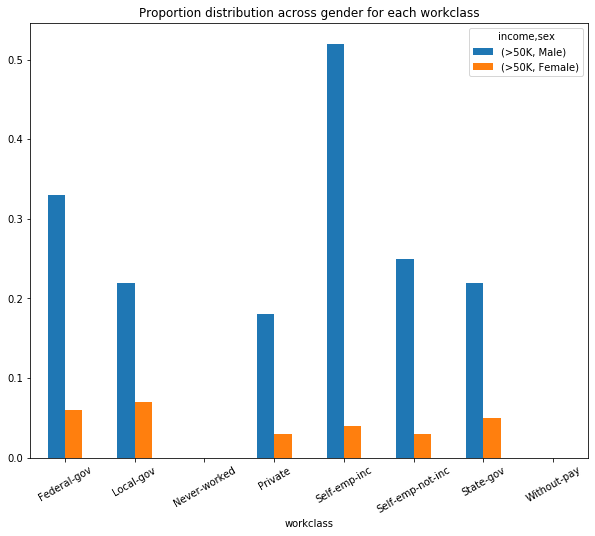

In [20]:

gender_workclass = round(pd.crosstab(df.workclass, [df.income,df.sex]).div(pd.crosstab(df.workclass, [df.income, df.sex]).apply(sum,1),0),2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind = 'bar', title = 'Proportion distribution across gender for each workclass', figsize = (10,8), rot = 30)
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('Taking a closer look at the disparity in income between men and women, plot the \
        proportion of men and women who earn more than 50k a year, across all the working \
        classes as seen in Fig. 3. We see that men always have a higher proportion earning \
        more than 50k a year than women, except for the \'without.pay\' working class, where \
        they have the same proportion.')

## 2.3. Occupation vs Income

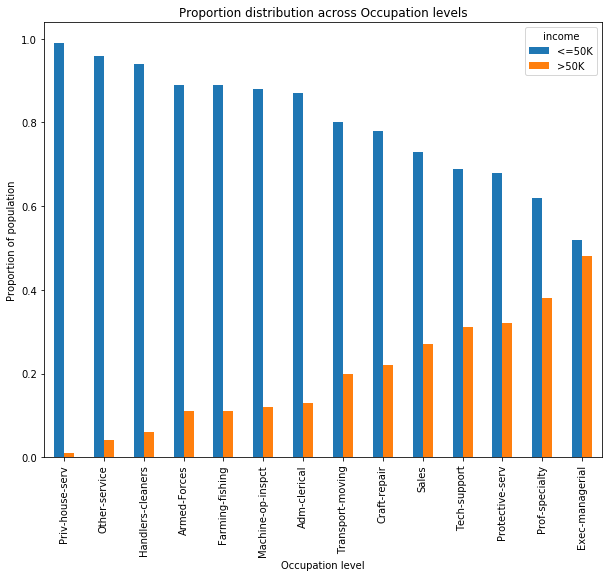

In [21]:

printmd('## 2.3. Occupation vs Income')

occupation = round(pd.crosstab(df.occupation,df.income).div(pd.crosstab(df.occupation,df.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)
ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

print()

## 2.4. Workclass vs Income

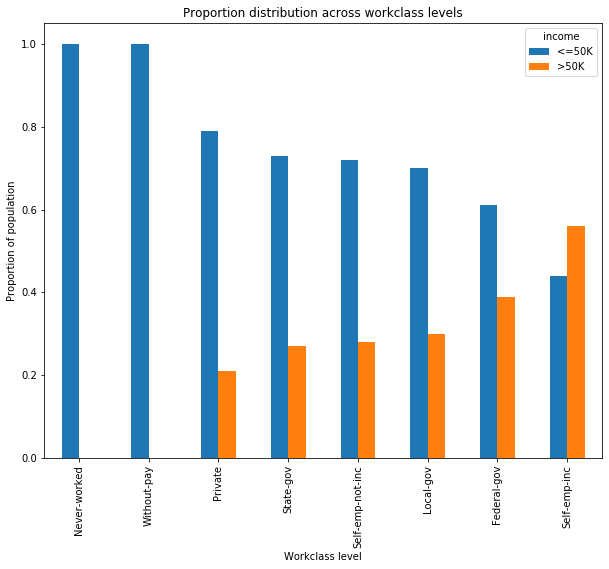

In [22]:

printmd('## 2.4. Workclass vs Income')

workclass = round(pd.crosstab(df.workclass, df.income).div(pd.crosstab(df.workclass, df.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass levels', figsize = (10,8))
ax.set_xlabel('Workclass level')
ax.set_ylabel('Proportion of population')

print()

## 2.5. Race vs Income

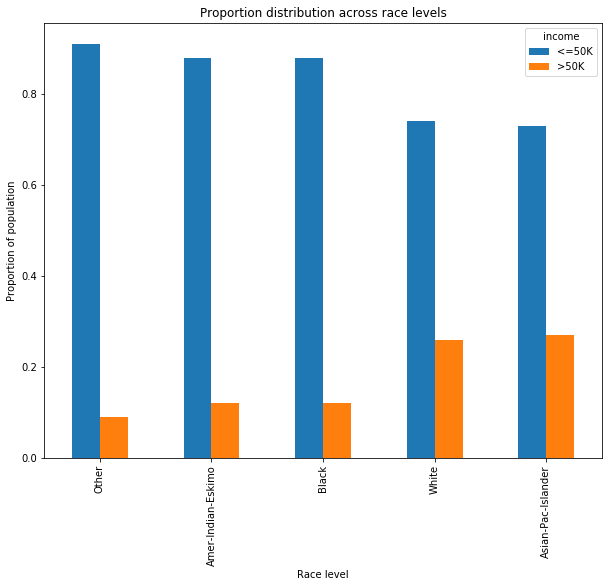

In [23]:
printmd('## 2.5. Race vs Income')

race = round(pd.crosstab(df.race,df.income).div(pd.crosstab(df.race, df.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)
ax = race.plot(kind ='bar', title = 'Proportion distribution across race levels', figsize = (10,8))
ax.set_xlabel('Race level')
ax.set_ylabel('Proportion of population')

print()

I plot a bar graph showing the proportion of income classes across the native country in figure         below. From the graph, we notice a trend in positioning of the country. South American country are         at the left end of the plot, with low proportion of population that make more than 50k a year. The         United States is located somewhat centrally, and at the right are countries from Europe and Asia,         with higher proportion of population that make more than 50k a year.

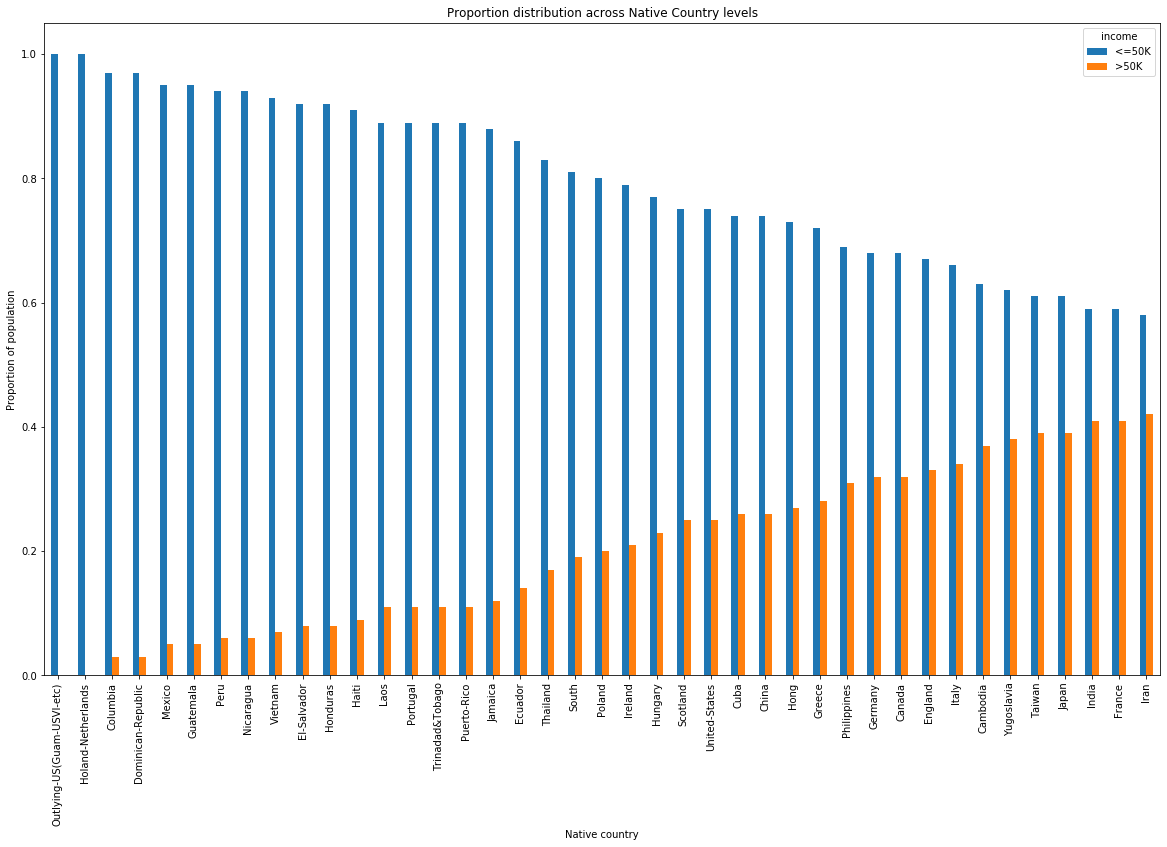

In [24]:

native_country = round(pd.crosstab(df['native.country'], df.income).div(pd.crosstab(df['native.country'], df.income).apply(sum,1),0),2)
native_country.sort_values(by = '>50K', inplace = True)
ax = native_country.plot(kind ='bar', title = 'Proportion distribution across Native Country levels', figsize = (20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the native country in figure \
        below. From the graph, we notice a trend in positioning of the country. South American country are \
        at the left end of the plot, with low proportion of population that make more than 50k a year. The \
        United States is located somewhat centrally, and at the right are countries from Europe and Asia, \
        with higher proportion of population that make more than 50k a year.')

## 2.7. Hours per week vs Income

I plot a bar graph showing the proportion of income classes across the hours worked.         We would expected to notice a trend that higher the hours worked per week, the higher the proportion         of population making more than 50k a year. However, this was not necessarily true from the graph.         For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on)         no one earned more than 50k a year. 

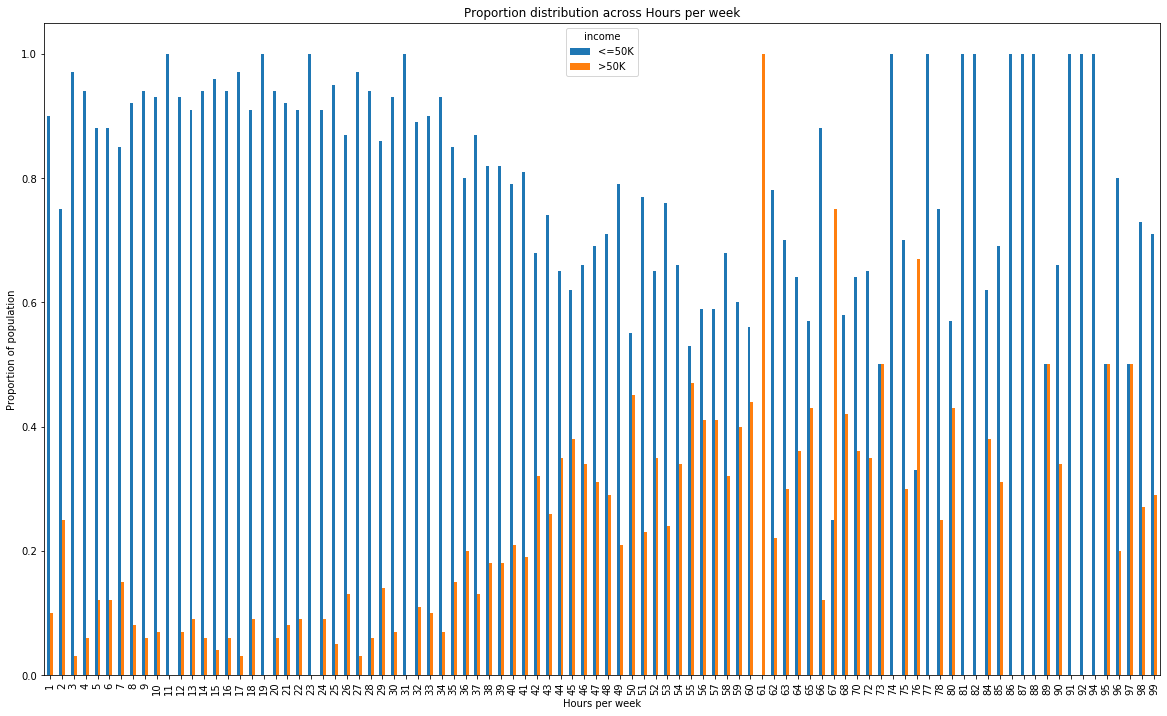

In [25]:
printmd('## 2.7. Hours per week vs Income')

hours_per_week = round(pd.crosstab(df['hours.per.week'],df.income).div(pd.crosstab(df['hours.per.week'], df.income).apply(sum,1),0),2)
# hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (20,12))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the hours worked. \
        We would expected to notice a trend that higher the hours worked per week, the higher the proportion \
        of population making more than 50k a year. However, this was not necessarily true from the graph. \
        For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on) \
        no one earned more than 50k a year. ')

### 2.7.1 Hours per week with categories

Therefore, I decided to transform this column into 3 categories, less than 40 hours,         40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories,         we can see from the figure below that there is an increasing trend in the proportion of         population making more than 50k a year.

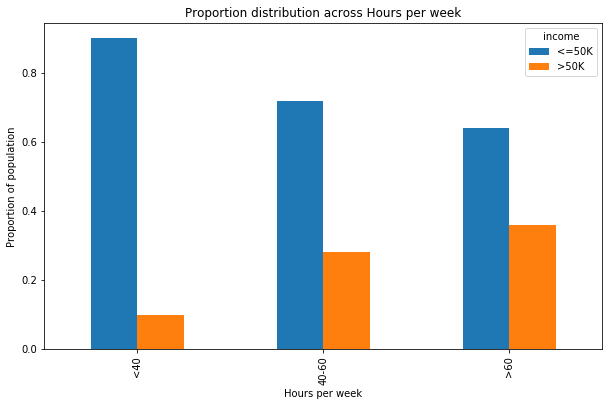

In [26]:

printmd('### 2.7.1 Hours per week with categories')

df['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in df['hours.per.week']]
df['hour_worked_bins'] = df['hour_worked_bins'].astype('category')
hours_per_week = round(pd.crosstab(df.hour_worked_bins, df.income).div(pd.crosstab(df.hour_worked_bins,df.income).apply(sum,1),0),2)

hours_per_week.sort_values(by = '>50K', inplace = True)
ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('Therefore, I decided to transform this column into 3 categories, less than 40 hours, \
        40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories, \
        we can see from the figure below that there is an increasing trend in the proportion of \
        population making more than 50k a year.')


### 2.7.2 Hours worked across working classes

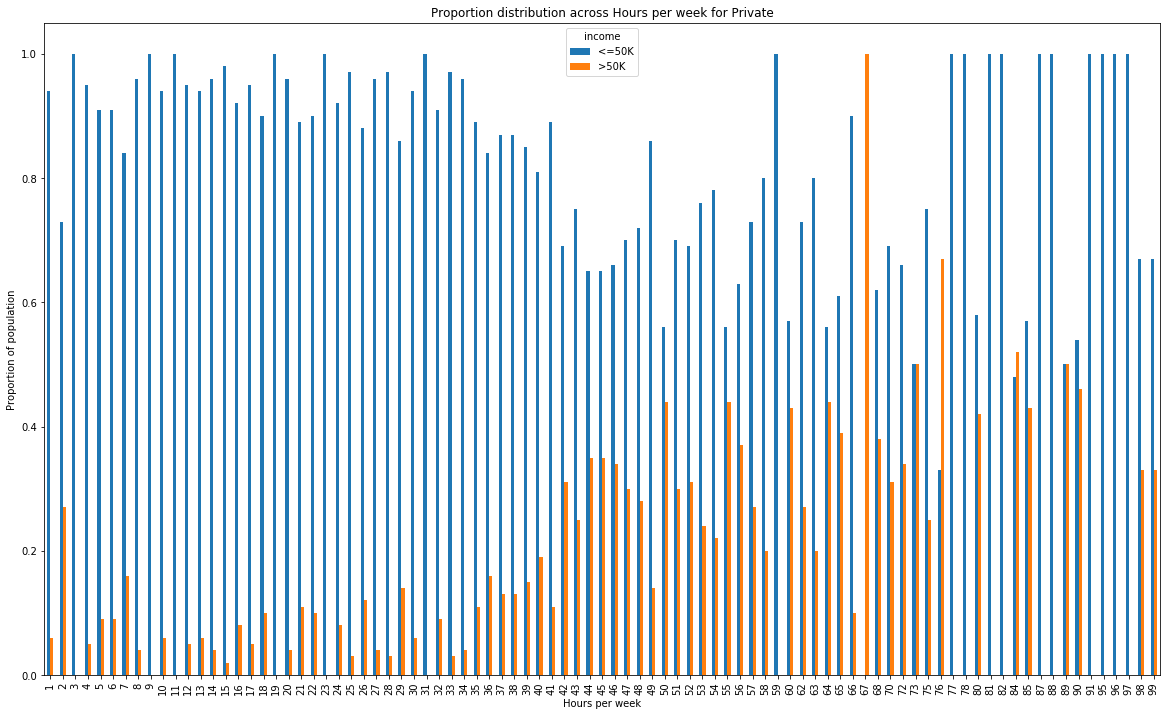

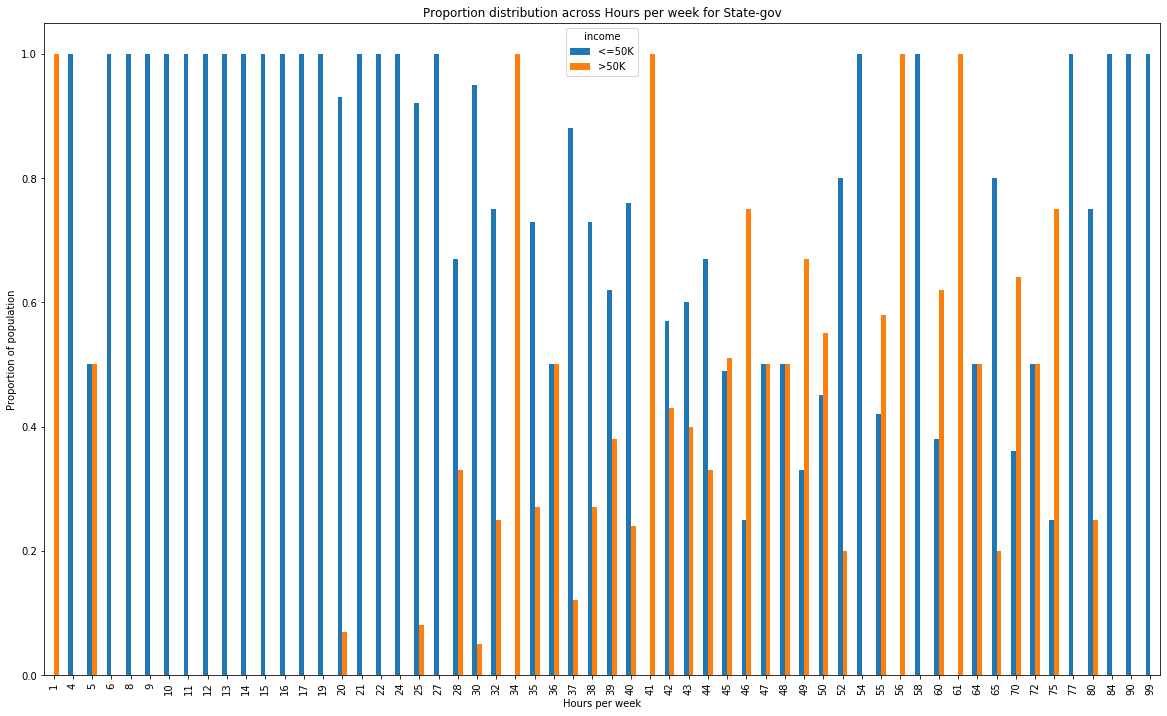

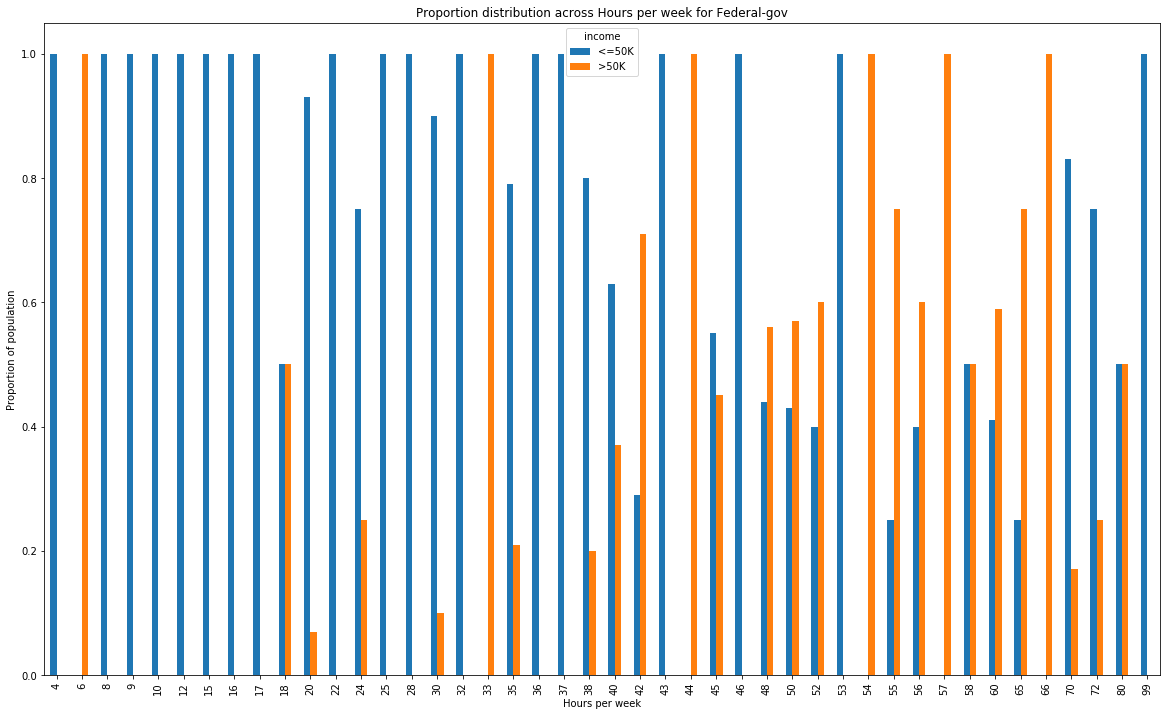

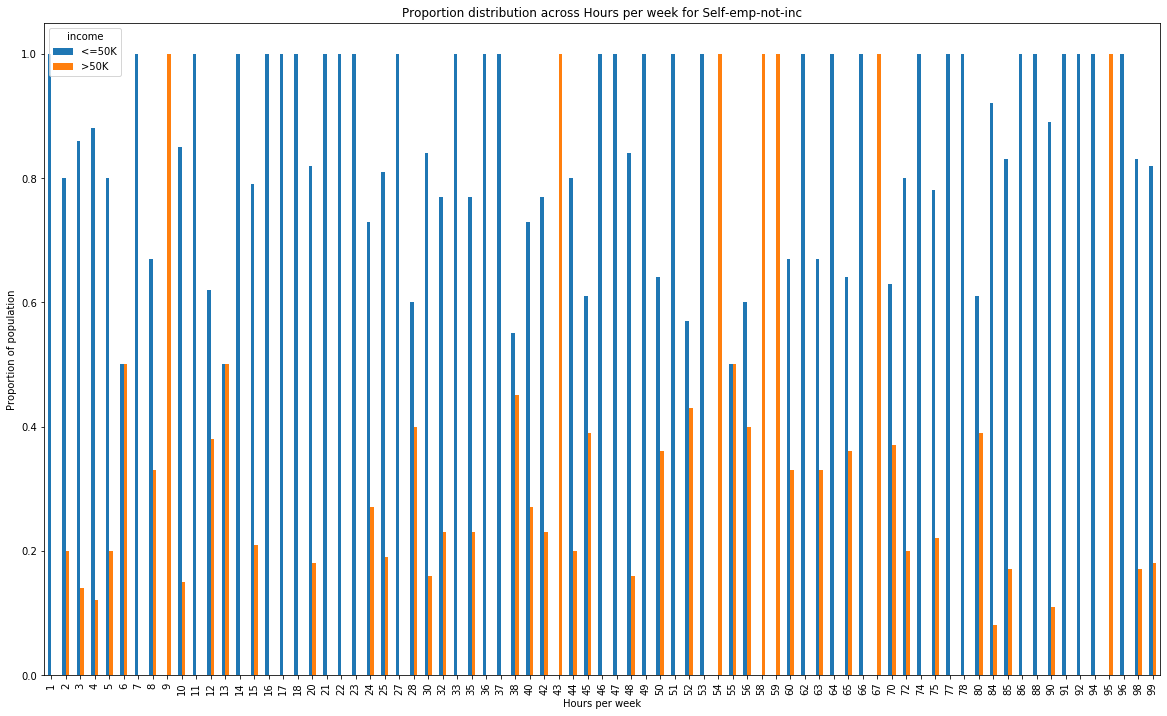

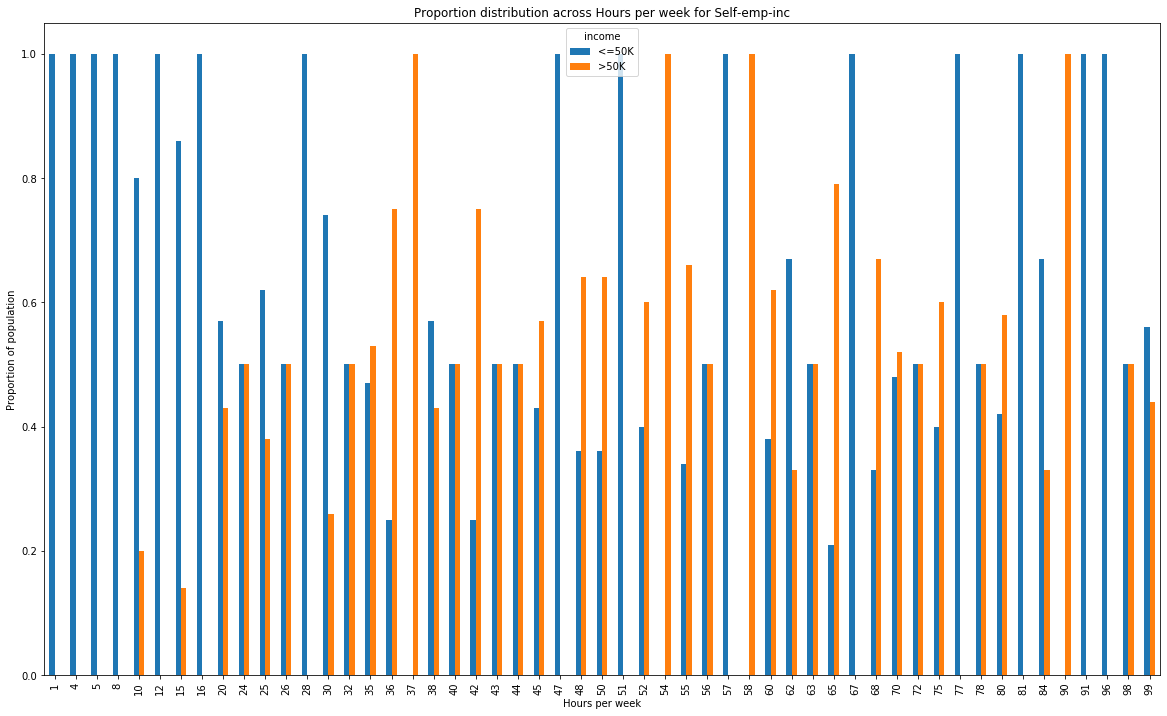

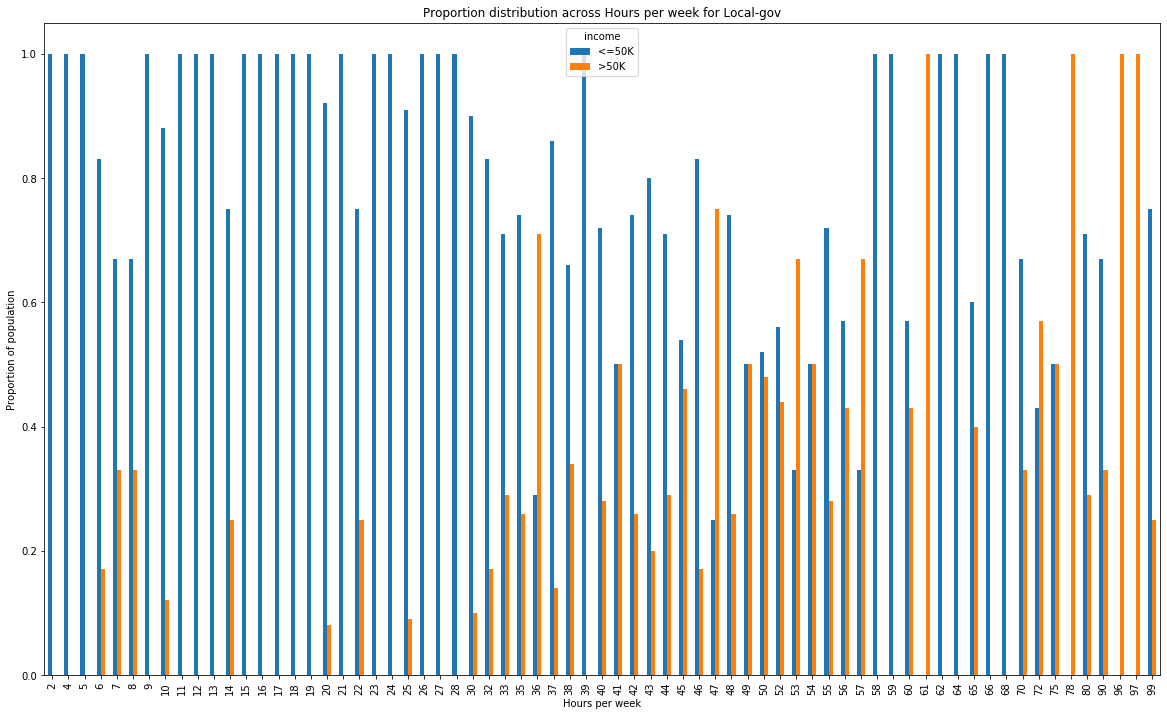

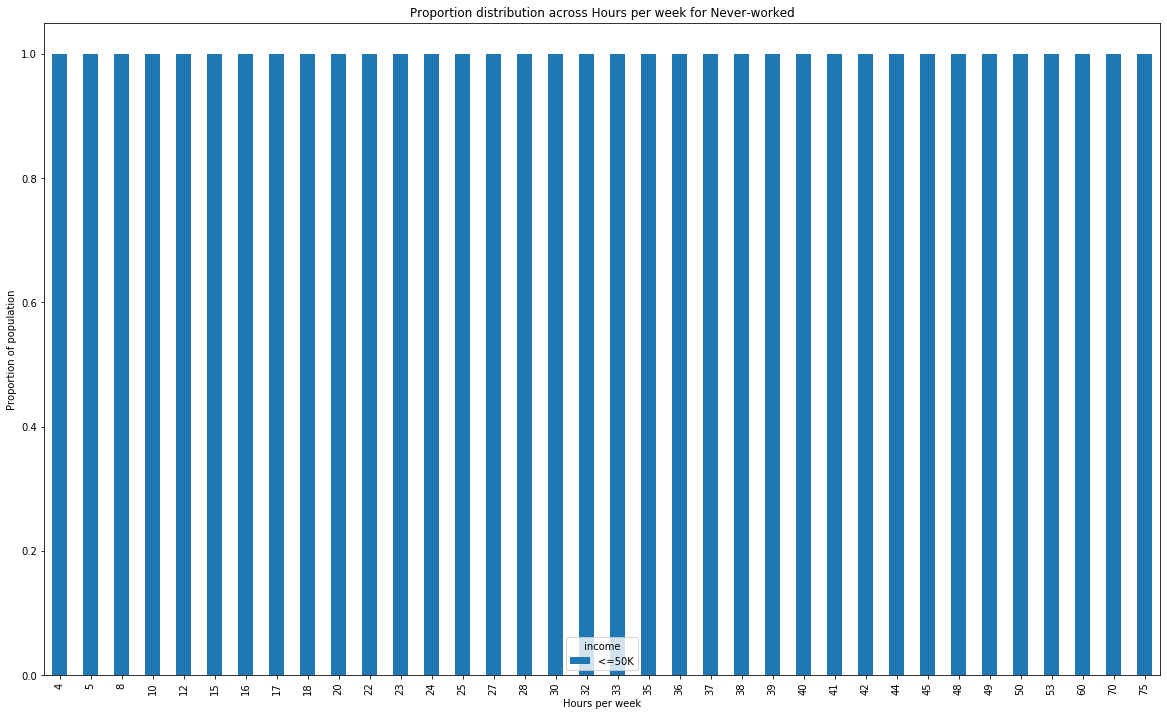

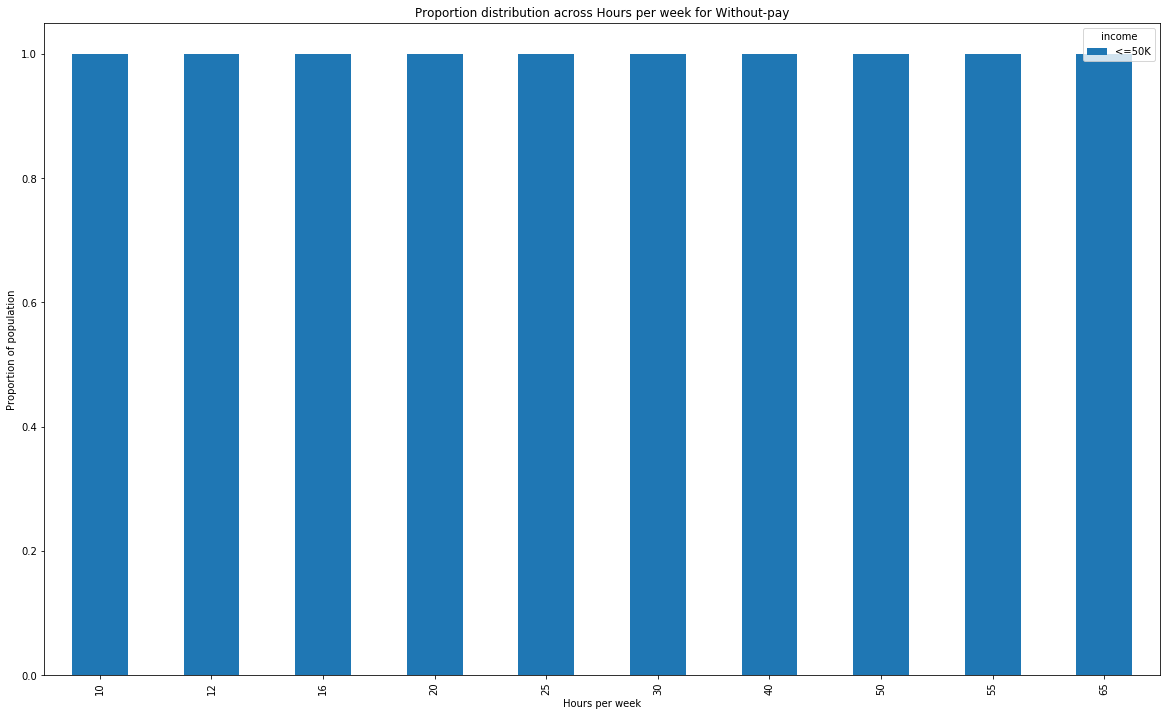

In [27]:
printmd('### 2.7.2 Hours worked across working classes')

for i in df.workclass.unique():
    ds = df[df.workclass == i]

    hours_per_week = round(pd.crosstab(ds['hours.per.week'], ds.income).div(pd.crosstab(ds['hours.per.week'], ds.income).apply(sum,1),0),2)
    # hours_per_week.sort_values(by = '>50K', inplace = True)
    ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week for '+ i, figsize = (20,12))
    ax.set_xlabel('Hours per week')
    ax.set_ylabel('Proportion of population')

    print()

# 3. Data Transformations

# 3.1. Feature Selection

In [28]:
# Remove education and fnlwgt
#df.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

printmd('* For education level, we have 2 features that convey the same meaning, \'education\' \
        and \'educational-num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
printmd('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
printmd('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')

* For education level, we have 2 features that convey the same meaning, 'education'         and 'educational-num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.

* I use the categorical Hours work column and drop the 'hour-per-week' column

* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.

# 3.2 Normalization

## Box plot

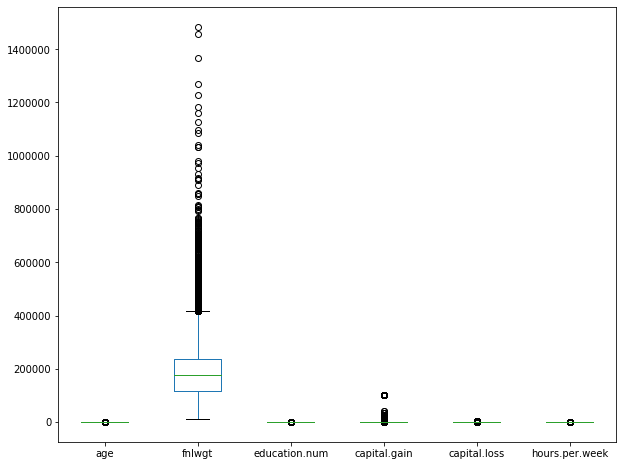

In [29]:
printmd('## Box plot')
df.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

In [30]:

printmd ('Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. ')

Normalization happens on the training dataset, by removing the mean and         scaling to unit variance. These values are stored and then later applied          to the test data before the test data is passed to the model for prediction. 

# 4. Model Development & Classification

# 4.1. Data Preparation

One-hot encoding is the process of representing multi-class categorical features as binary features, one for each class. Although this process increases the dimensionality of the dataset, classification algorithms tend to work better on this format of data.

I use one-hot encoding to represent all the categorical features in the dataset.

# 'One Hot Encoding'

In [31]:
# Data Prep
adult_data = df.drop(columns = ['income'])
adult_label = df.income


adult_cat_1hot = pd.get_dummies(adult_data.select_dtypes('category'))
adult_non_cat = adult_data.select_dtypes(exclude = 'category')

adult_data_1hot = pd.concat([adult_non_cat, adult_cat_1hot], axis=1, join='inner')

# 'Train-Test-Split'

In [32]:

# Train - Test split
train_data, test_data, train_label, test_label = train_test_split(adult_data_1hot, adult_label, test_size  = 0.25)

# 'Standard Scaling'

In [33]:
# Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

# Fitting only on training data
scaler.fit(train_data)  
train_data = scaler.transform(train_data)  

# Applying same transformation to test data
test_data = scaler.transform(test_data)

In [34]:
def model_eval(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc['>50K','>50K']
    TN = confusion.loc['<=50K','<=50K']
    FP = confusion.loc['<=50K','>50K']
    FN = confusion.loc['>50K','<=50K']

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

# 4.2. Model Development

# 4.2.1. Decision Tree

For the decision tree classifier, I experimented with the splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

Splitting criteria: Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
Min samples required to split: 5% (Best amongst 1%, 10% and 5%.)
Max Depth: None
Min samples required at leaf: 0.1 % (Best amongst 1%, 5% and 0.1%.)
Max features: number of features (Performs better than 'auto', 'log2' and 'sqrt'.)

In [35]:
printmd('### 3.1.1. Model Development ')

# Gini 
clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', min_samples_split = 0.05, min_samples_leaf = 0.001, max_features = None)
clf_gini = clf_gini.fit(train_data, train_label)
clf_gini_pred = clf_gini.predict(test_data)
DTree_Gini = model_eval(test_label, clf_gini_pred)
print('Desicion Tree using Gini Index : %.2f percent.' % (round(DTree_Gini['accuracy']*100,2)))


# Entropy
clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 0.05, min_samples_leaf = 0.001)
clf_entropy = clf_entropy.fit(train_data, train_label)
clf_entropy_pred = clf_entropy.predict(test_data)
DTree_Entropy = model_eval(test_label, clf_entropy_pred)
print('Desicion Tree using Entropy : %.2f percent.' % (round(DTree_Entropy['accuracy']*100,2)))


#printmd('### 3.1.2. Model Evaulation ')
ovl_dtree = round(pd.DataFrame([DTree_Entropy, DTree_Gini], index = ['DTree_Entropy','DTree_Gini']),4)
display(ovl_dtree)

### 3.1.1. Model Development 

Desicion Tree using Gini Index : 85.60 percent.
Desicion Tree using Entropy : 85.53 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
DTree_Entropy,0.8553,0.7357,0.6265,0.6767,0.6265,0.9282,0.1447
DTree_Gini,0.8560,0.7392,0.6250,0.6773,0.6250,0.9297,0.1440


# 4.2.3. Support Vector Machine

For the SVM classifier, I experimented with the various available kernels, the penalty of the error term and the tolerance for stopping criteria. The following values of the parameters attained the best accuracy during classification. Results in the table below.

Kernel: rbf (Marginally outperformed 'linear, 'poly' and 'sigmoid' kernels.)
C, penalty of the error term: 1 (Best amongst 0.1, 0.5, 1 and 10)
Tolerance for stopping criteria: 1e-3 (Best amongst 1e-1, 1e-2, 1e-3, 1e-4 and 1e-5)

In [36]:
# rbf kernal
svm_clf_rbf = svm.SVC(kernel = 'rbf', C = 1, tol = 1e-3)
svm_clf_rbf.fit(train_data, train_label)
svm_clf_rbf_pred = svm_clf_rbf.predict(test_data)
SVM_rbf = model_eval(test_label, svm_clf_rbf_pred)
print('SVM using rbf kernel : %.2f percent.' % (round(SVM_rbf['accuracy']*100,2)))

# Linear kernel
svm_clf_linear = svm.SVC(kernel = 'linear')
svm_clf_linear.fit(train_data, train_label)
svm_clf_linear_pred = svm_clf_linear.predict(test_data)
SVM_linear = model_eval(test_label, svm_clf_linear_pred)
print('SVM using linear kernel : %.2f percent.' % (round(SVM_linear['accuracy']*100,2)))


# Poly kernal
svm_clf_poly = svm.SVC(kernel = 'poly')
svm_clf_poly.fit(train_data, train_label)
svm_clf_poly_pred = svm_clf_poly.predict(test_data)
SVM_poly = model_eval(test_label, svm_clf_poly_pred)
print('SVM using poly kernel : %.2f percent.' % (round(SVM_poly['accuracy']*100,2)))


svm_clf_sigmoid = svm.SVC(kernel = 'sigmoid')
svm_clf_sigmoid.fit(train_data, train_label)
svm_clf_sigmoid_pred = svm_clf_sigmoid.predict(test_data)
SVM_sigmoid = model_eval(test_label, svm_clf_sigmoid_pred)
print('SVM using sigmoid kernel : %.2f percent.' % (round(SVM_sigmoid['accuracy']*100,2)))



#printmd('### 3.3.2. Model Evaulation ')
ovl_svm = round(pd.DataFrame([SVM_rbf, SVM_linear, SVM_poly, SVM_sigmoid], index = ['SVM_rbf','SVM_linear', 'SVM_poly', 'SVM_sigmoid']),4)
display(ovl_svm)

SVM using rbf kernel : 84.92 percent.
SVM using linear kernel : 85.48 percent.
SVM using poly kernel : 82.96 percent.
SVM using sigmoid kernel : 82.85 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
SVM_rbf,0.8492,0.7493,0.5650,0.6443,0.5650,0.9397,0.1508
SVM_linear,0.8548,0.7606,0.5828,0.6600,0.5828,0.9415,0.1452
SVM_poly,0.8296,0.7216,0.4807,0.5770,0.4807,0.9409,0.1704
SVM_sigmoid,0.8285,0.6763,0.5574,0.6111,0.5574,0.9150,0.1715


# 4.2.4. Ensemble Models

4.2.4.1. Random Forest¶
For the random forests classifier, I experimented with the number of trees, splitting criteria, minimum samples required to split, max depth of the tree, minimum samples required at the leaf level and the maximum features to consider when looking for the best split. The following values of the parameters attained the best accuracy during classification. Results in the table below.

Num estimators: 100 (Best amongst 10, 50 and 100)
Splitting criteria: Gini Index (Using Gini Index marginally outperformed Entropy with a higher accuracy.)
Min samples required to split: 5% (Best amongst 1%, 10% and 5%.)
Max Depth: None
Min samples required at leaf: 0.1 % (Best amongst 1%, 5% and 0.1%.)
Max features: number of features (Performs better than 'auto', 'log2' and 'sqrt'.)

In [37]:
# Gini
r_forest_gini = RandomForestClassifier(n_estimators=100, criterion = 'gini', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_gini.fit(train_data, train_label)
r_forest_gini_pred = r_forest_gini.predict(test_data)
rforest_gini = model_eval(test_label, r_forest_gini_pred)
print('Random Forest using Gini Index : %.2f percent.' % (round(rforest_gini['accuracy']*100,2)))

# Entropy
r_forest_entropy = RandomForestClassifier(n_estimators=100, criterion = 'entropy', max_features = None,  min_samples_split = 0.05, min_samples_leaf = 0.001)
r_forest_entropy.fit(train_data, train_label)
r_forest_entropy_pred = r_forest_entropy.predict(test_data)
rforest_entropy = model_eval(test_label, r_forest_entropy_pred)
print('Random Forest using Entropy : %.2f percent.' % (round(rforest_entropy['accuracy']*100,2)))

#printmd('### 3.4.1.2. Model Evaulation ')
ovl_rf = round(pd.DataFrame([rforest_gini, rforest_entropy], index = ['rforest_gini','rforest_entropy']),4)
display(ovl_rf)

Random Forest using Gini Index : 85.30 percent.
Random Forest using Entropy : 85.47 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
rforest_gini,0.8530,0.7901,0.5335,0.6369,0.5335,0.9548,0.1470
rforest_entropy,0.8547,0.7940,0.5386,0.6418,0.5386,0.9555,0.1453


# 4.2.4.2. Adaboost

For the adaboost classifier, I experimented with base estimator from which the boosted ensemble is built and number of estimators. The following values of the parameters attained the best accuracy during classification. Results in the table below.

Base Estimator: DecisionTreeClassifier
Num estimators: 100 (Best amongst 10, 50 and 100.)

In [38]:
ada = AdaBoostClassifier(n_estimators=100)                     
ada.fit(train_data, train_label)
ada_pred = ada.predict(test_data)
adaboost = model_eval(test_label, ada_pred)
print('Adaboost : %.2f percent.' % (round(adaboost['accuracy']*100,2)))

#printmd('### 3.4.2.2. Model Evaulation ')
ovl_ada = round(pd.DataFrame([adaboost], index = ['adaboost']),4)
display(ovl_ada)

Adaboost : 86.61 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8661,0.7821,0.6184,0.6907,0.6184,0.9451,0.1339


# 4.2.5. Logistic Regression

In [39]:
log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)
logistic_reg = model_eval(test_label, log_reg_pred)
print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

#printmd('### 3.5.2. Model Evaulation ')
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),4)
display(ovl_logreg)

Logistic Regression : 85.65 percent.


,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.8565,0.7528,0.6052,0.671,0.6052,0.9367,0.1435


# Model Evaluation

In [40]:

overall_eval = pd.concat([ovl_dtree, ovl_svm, ovl_rf, ovl_ada, ovl_logreg], axis = 0)
overall_eval.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

printmd('Combing the performance statistics of all the model developed, as seen in table below, \
        we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7812) \
        and accuracy (0.8647). The Artificial neural network models are only marginally being in terms of \
        accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, expect for two SVM \
        models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and \
        specificity of all the models developed.')

display(overall_eval)

Combing the performance statistics of all the model developed, as seen in table below,         we see that the ensemble model Adaboost hast the highest F-measure (0.6833), precision (0.7812)         and accuracy (0.8647). The Artificial neural network models are only marginally being in terms of         accuracy and F-measure. Almost all the model have an accuracy greater than 0.84, expect for two SVM         models. The table below lists the accuracy, error rate, F-measure, precision, recall, sensitivity and         specificity of all the models developed.

,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
adaboost,0.8661,0.7821,0.6184,0.6907,0.6184,0.9451,0.1339
DTree_Gini,0.8560,0.7392,0.6250,0.6773,0.6250,0.9297,0.1440
DTree_Entropy,0.8553,0.7357,0.6265,0.6767,0.6265,0.9282,0.1447
logistic_reg,0.8565,0.7528,0.6052,0.6710,0.6052,0.9367,0.1435
SVM_linear,0.8548,0.7606,0.5828,0.6600,0.5828,0.9415,0.1452
SVM_rbf,0.8492,0.7493,0.5650,0.6443,0.5650,0.9397,0.1508
rforest_entropy,0.8547,0.7940,0.5386,0.6418,0.5386,0.9555,0.1453
rforest_gini,0.8530,0.7901,0.5335,0.6369,0.5335,0.9548,0.1470
SVM_sigmoid,0.8285,0.6763,0.5574,0.6111,0.5574,0.9150,0.1715
SVM_poly,0.8296,0.7216,0.4807,0.5770,0.4807,0.9409,0.1704


# Saving the predicted result in CSV file

In [43]:
ada_pred=pd.DataFrame(ada_pred,columns=['ada_pred']).to_csv('Income.csv')

# Saving the best Model as a pickle in a file

Adaboost Model is giving highest accuracy score.Hence it is the best model

In [45]:
from sklearn.externals import joblib

In [46]:
joblib.dump(ada,'Income.pkl')

['Income.pkl']